## Analysis

In [3]:
import pandas as pd
from ast import literal_eval
import seaborn as sns
import matplotlib as plt
import re

In [4]:
df = pd.read_csv('data_v2/wiki-dataset-results-1k.csv')

In [5]:
# all columns with objects stored as strings have to be evaluated back to objects
objectTypeCols = [
    'sentences',
    'paraphrased_sentences',
    'normal_entities',
    'paraphrased_entities',
    'normal_predictions',
    'paraphrased_predictions',
    'normal_prediction_tokens',
    'paraphrased_prediction_tokens'
    ]

for col in objectTypeCols:
    df[col] = df[col].apply(lambda cell: literal_eval(cell))

In [6]:
# convert numpy number types to native python for processing
# with autoviz
df['normal_scores'] = df['normal_scores'].apply(lambda cell: int(cell))
df['paraphrased_scores'] = df['paraphrased_scores'].apply(lambda cell: int(cell)) #.item())

In [7]:
df.shape

(929, 22)

In [8]:
# text lengths after preprocessing
df['normal_text_length'] = df['normal_text'].apply(lambda text: len(text))
df['paraphrased_text_length'] = df['paraphrased_text'].apply(lambda text: len(text))

In [9]:
# number of sentences in each wiki page after preprocessing
# sentences were used for paraphrasing. Later joined back together for NER and fill-mask
df['normal_sentences_count'] = df['sentences'].apply(lambda array: len(array))
df['paraphrased_sentences_count'] = df['paraphrased_sentences'].apply(lambda array: len(array))

In [10]:
# number of masks present in text ready for processing
df['normal_mask_count'] = df['normal_masked_text'].apply(lambda text: len([*re.finditer('<mask>', text)]))
df['paraphrased_mask_count'] = df['paraphrased_masked_text'].apply(lambda text: len([*re.finditer('<mask>', text)]))

In [11]:
# count of entities detected by NER, where masking can be applied (entities which
# are not the person the wiki page is about are filtered out)
df['normal_entities_count'] = df['normal_entities'].apply(lambda arr: len(arr))
df['paraphrased_entities_count'] = df['paraphrased_entities'].apply(lambda arr: len(arr))

In [12]:
# top 20 scorer numbers of different metrics compared by paraphrased or not
# TODO

In [13]:
# worst 20 scorer numbers of different metrics compared by paraphrased or not
# TODO

In [14]:
# compare average of trimmed characters by paraphrasing
# TODO

## analysis of average scorings

In [15]:
# average numbers of different metrics compared by paraphrased or not
# CAREFUL: this excludes examples which were lost during computation (due to NER not detecting any entities)
print("NORMAL Average masks count per page: {}".format(round(df['normal_entities_count'].mean(),2)))
print("PARAPH Average masks count per page: {}".format(round(df['paraphrased_entities_count'].mean(),2)))
print("")
print("NORMAL Average score per page: {}".format(round(df['normal_scores'].mean(),2)))
print("PARAPH Average score per page: {}".format(round(df['paraphrased_scores'].mean(),2)))
print("")
print("NORMAL Average text length: {}".format(round(df['normal_text_length'].mean(),2)))
print("PARAPH Average text length: {}".format(round(df['paraphrased_text_length'].mean(),2)))

NORMAL Average masks count per page: 10.48
PARAPH Average masks count per page: 7.06

NORMAL Average score per page: 26.46
PARAPH Average score per page: 20.41

NORMAL Average text length: 3492.85
PARAPH Average text length: 2381.76


## analysis of bad scores
- N: normal
- P: paraphrased

In [16]:
# how many rows did not have any masks to predict and therefore no predictions?
Nzero = len(df.loc[df['normal_entities_count'] == 0])
Pzero = len(df.loc[df['paraphrased_entities_count'] == 0])

print("NORMAL {}/{} ({}%) did not have any masks to predict".format(Nzero, df.shape[0], round(100 / df.shape[0] * Nzero,2)))
print("PARAPH {}/{} ({}%) did not have any masks to predict".format(Pzero, df.shape[0], round(100 / df.shape[0] * Pzero,2)))

NORMAL 6/929 (0.65%) did not have any masks to predict
PARAPH 0/929 (0.0%) did not have any masks to predict


In [17]:
# how many rows did not correctly predict any mask at all? (without those that had no masks to predict)
NzeroPredictedEntitiesRows = df.loc[(df['normal_scores'] == 0) & (df['normal_entities_count'] > 0)]
PzeroPredictedEntitiesRows = df.loc[(df['paraphrased_scores'] == 0) & (df['normal_entities_count'] > 0)]
NCount = len(NzeroPredictedEntitiesRows)
PCount = len(PzeroPredictedEntitiesRows)
Npercent = round(100 / df.shape[0] * NCount, 2)
Ppercent = round(100 / df.shape[0] * PCount, 2)
print("NORMAL No mask correctly predicted for {}/{} pages ({}%)".format(NCount, df.shape[0], Npercent))
print("PARAPH No mask correctly predicted for {}/{} pages ({}%)".format(PCount, df.shape[0], Ppercent))

NORMAL No mask correctly predicted for 326/929 pages (35.09%)
PARAPH No mask correctly predicted for 512/929 pages (55.11%)


In [18]:
# what was the average text length for those which did not contain a single entity?
NzeroPredictedEntitiesRows = df.loc[(df['normal_scores'] == 0) & (df['normal_entities_count'] > 0)]
PzeroPredictedEntitiesRows = df.loc[(df['paraphrased_scores'] == 0) & (df['normal_entities_count'] > 0)]
print("NORMAL average text length for 0 score: {} chars".format(round(NzeroPredictedEntitiesRows['normal_text_length'].mean(),2)))
print("PARAPH average text length for 0 score: {} chars".format(round(PzeroPredictedEntitiesRows['normal_text_length'].mean(),2)))

NORMAL average text length for 0 score: 3086.84 chars
PARAPH average text length for 0 score: 3297.79 chars


## Basic graphs

(0.0, 4100.0)

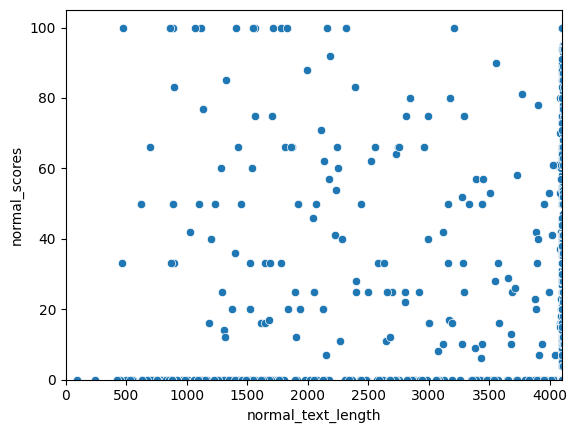

In [19]:
# compare score to text length
# fig, ax = plt.subplots()
gf = sns.scatterplot(data=df, x='normal_text_length', y='normal_scores')
gf.set_ylim(0, 105)
gf.set_xlim(0, 4100)
# Graph is cut at 4k characters, as we cut text-lengths there to have enough text for processing.
# text was cut after the first 4k, as most information is within the first few characters

In [20]:
## Normal Text
## How many % of pages scores > 0 for different page-lengths?
above4k = df.loc[(df['normal_text_length'] >= 4000)]
above4kScores = above4k.loc[above4k['normal_scores'] > 0]
below4k = df.loc[(df['normal_text_length'] < 4000)]
below4kScores = below4k.loc[below4k['normal_scores'] > 0]
with34k = df.loc[(df['normal_text_length'] >= 2000) & (df['normal_text_length'] < 3000)]
with34kScores = with34k.loc[with34k['normal_scores'] > 0]

print(with34kScores.shape)

print("NORMAL TEXT")
args1 = (round(100 / above4k.shape[0] * above4kScores.shape[0], 2), above4kScores.shape[0], above4k.shape[0])
args2 = (round(100 / below4k.shape[0] * below4kScores.shape[0], 2), below4kScores.shape[0], below4k.shape[0])
args3 = (round(100 / with34k.shape[0] * with34kScores.shape[0], 2), with34kScores.shape[0], with34k.shape[0])
print("Texts with score > 0% with >=4k text: {}% ({}/{} pages)".format(*args1))
print("Texts with score > 0% with < 4k text: {}% ({}/{} pages)".format(*args2))
print("Texts with score > 0% with 2-3k text: {}% ({}/{} pages)".format(*args3))

print()

## Paraphrased Text
above4k = df.loc[(df['paraphrased_text_length'] >= 4000)]
above4kScores = above4k.loc[above4k['paraphrased_scores'] > 0]
below4k = df.loc[(df['paraphrased_text_length'] < 4000)]
below4kScores = below4k.loc[below4k['paraphrased_scores'] > 0]
with34k = df.loc[(df['paraphrased_text_length'] >= 2000) & (df['paraphrased_text_length'] < 3000)]
with34kScores = with34k.loc[with34k['paraphrased_scores'] > 0]

print("PARAPHRASED TEXT")
args1 = (round(100 / above4k.shape[0] * above4kScores.shape[0], 2), above4kScores.shape[0], above4k.shape[0])
args2 = (round(100 / below4k.shape[0] * below4kScores.shape[0], 2), below4kScores.shape[0], below4k.shape[0])
args3 = (round(100 / with34k.shape[0] * with34kScores.shape[0], 2), with34kScores.shape[0], with34k.shape[0])
print("Texts with score > 0% with >=3.9k text: {}% ({}/{} pages)".format(*args1))
print("Texts with score > 0% with < 3.9k text: {}% ({}/{} pages)".format(*args2))
print("Texts with score > 0% with 2-3k text: {}% ({}/{} pages)".format(*args3))

(41, 30)
NORMAL TEXT
Texts with score > 0% with >=4k text: 72.58% (458/631 pages)
Texts with score > 0% with < 4k text: 46.64% (139/298 pages)
Texts with score > 0% with 2-3k text: 53.25% (41/77 pages)

PARAPHRASED TEXT
Texts with score > 0% with >=3.9k text: 57.14% (4/7 pages)
Texts with score > 0% with < 3.9k text: 44.36% (409/922 pages)
Texts with score > 0% with 2-3k text: 47.95% (234/488 pages)


In [21]:
import numpy as np

# plot length of sentences
allSentences = np.concatenate(df['sentences'].values)

In [22]:
allSentencesLengths = [len(sentence) for sentence in allSentences]
print("Longest sentences: {} characters".format(max(allSentencesLengths)))
print("Average sentence length: {} charcters".format(sum(allSentencesLengths) / len(allSentencesLengths)))
print("% sentences above 600 characters: ")

Longest sentences: 3025 characters
Average sentence length: 133.30427371746902 charcters
% sentences above 600 characters: 


In [23]:
max(allSentencesLengths)

3025

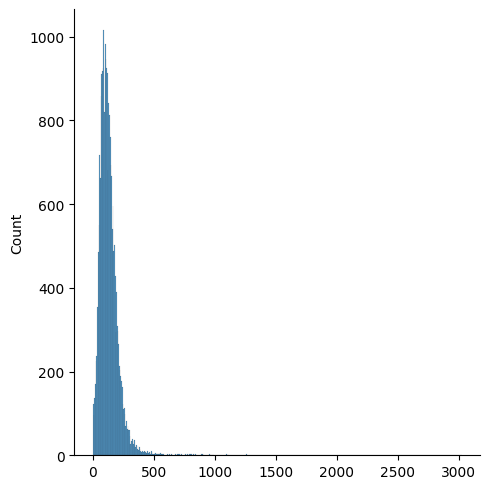

In [24]:
import matplotlib.pyplot as plt

plot = sns.displot(allSentencesLengths)
# plt.xlim(0, 1000)

In [25]:
res = reversed(sorted(allSentences, key=len))

In [156]:
next(res)

"Furthermore, Emperor Ai was highly controlled by his grandmother Consort Fu (consort of his grandfather and his predecessor's father Emperor Yuan), who demanded the title of Grand Empress Dowager—even though she had never been an empress previously and therefore did not properly hold that title, and this led to the unprecedented and unrepeated situation of four women possessing empress dowager titles at the same time—Empress Wang (Emperor Cheng's mother and Emperor Yuan's wife), Empress Zhao Feiyan (Emperor Cheng's wife), Consort Fu, and Consort Ding (Emperor Ai's mother)."

In [157]:
len("Furthermore, Emperor Ai was highly controlled by his grandmother Consort Fu (consort of his grandfather and his predecessor's father Emperor Yuan), who demanded the title of Grand Empress Dowager—even though she had never been an empress previously and therefore did not properly hold that title, and this led to the unprecedented and unrepeated situation of four women possessing empress dowager titles at the same time—Empress Wang (Emperor Cheng's mother and Emperor Yuan's wife), Empress Zhao Feiyan (Emperor Cheng's wife), Consort Fu, and Consort Ding (Emperor Ai's mother).")

579

## Interpretation
TBD

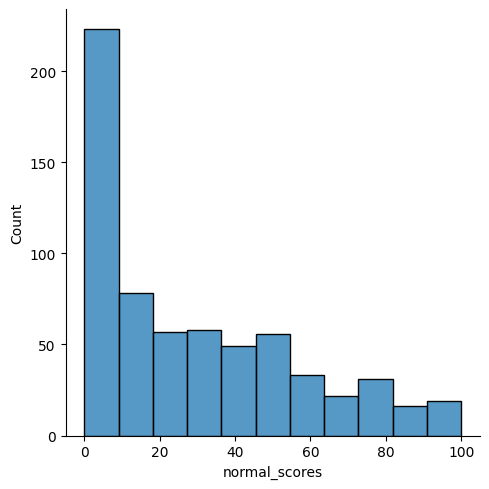

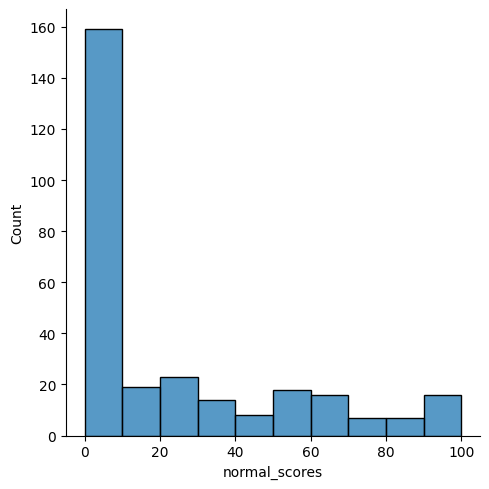

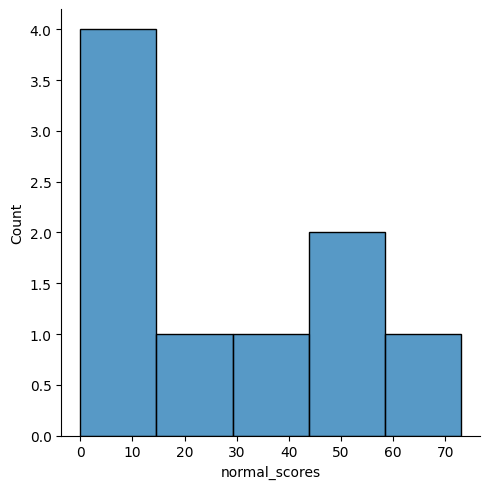

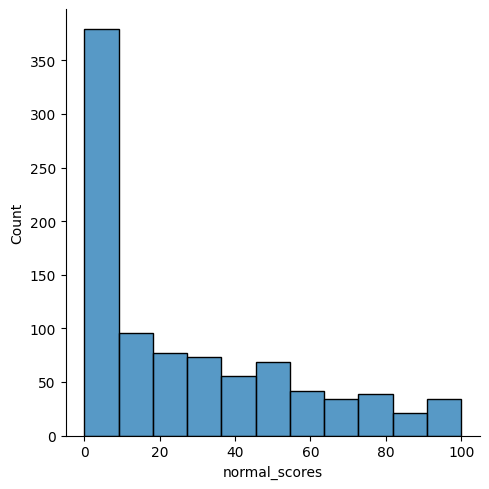

In [24]:
# score depending on text length above or below 4k characters
above4k = df.loc[(df['normal_text_length'] >= 3900)]
below4k = df.loc[(df['normal_text_length'] < 3900)]
sns.displot(above4k.normal_scores)
sns.displot(below4k.normal_scores)
# score depending on text length above or below 4k characters
above4k = df.loc[(df['paraphrased_text_length'] >= 3900)]
below4k = df.loc[(df['paraphrased_text_length'] < 3900)]
sns.displot(above4k.normal_scores)
sns.displot(below4k.normal_scores)

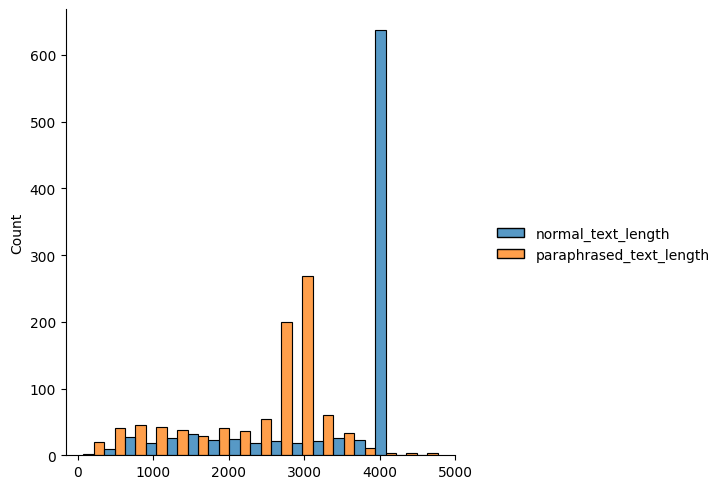

In [25]:
# text length distributions
sns.displot([df.normal_text_length, df.paraphrased_text_length], multiple='dodge')

### comparing mask counts to text and sentences length
We can see in the first figure below that paraphrasing shortened texts by about 1 fourth of their initial lengths, but did not reduce the amount of masks present after paraphrasing when compared to remaining text length. The mask count to text length proportion is very similar between paraphrasing and normal texts, only the overall mask count is different.

Comparing mask count by sentences however, we see that sentences do have less occurences of masks when paraphrased.
Therefore, paraphrasing does not necessarily remove masks compared to the overall text length, but it is likely to remove masks in sentences when it shortens them.

###### important points
- Paraphrasing regulary removes entities within sentences when shortening them
- Paraphrasing shortens texts, even when paraphrasing single sentences

###### Action Items
- [ ] Can we customize paraphrasing to rather keep entities within a sentences? Or delete less of the sentence and just rearrange it?

In [26]:
## Compare length of text to number of masks
plt.pyplot.figure(figsize=(15,8))
nf = sns.regplot(x=df['paraphrased_text_length'], y=df['paraphrased_mask_count'], label='Paraphrased')
nf = sns.regplot(x=df['normal_text_length'], y=df['normal_mask_count'], label='Normal')
nf.set_ylim(0, 50)
sns.set(font_scale=2)
# nf.set_xlim(4000)
nf.axhline(df['normal_mask_count'].mean(), ls='--', c='orange')
nf.axhline(df['paraphrased_mask_count'].mean(), ls='--')
nf.set(xlabel='text length')
nf.set(ylabel='number of masks')
nf.text(0, df['paraphrased_mask_count'].mean()+1, "paraphrased average", c='C0')
nf.text(0, df['normal_mask_count'].mean()+1, "normal average", c='orange')
nf.legend()
nf.set_title("mask count compared by text length")

## Compare sentences count to number of masks
## Compare length of text to number of masks
plt.pyplot.figure(figsize=(15,8))
nf = sns.regplot(x=df['paraphrased_sentences_count'], y=df['paraphrased_mask_count'], label='Paraphrased')
nf = sns.regplot(x=df['normal_sentences_count'], y=df['normal_mask_count'], label='Normal')
nf.set_ylim(0, 50)
# nf.set_xlim(4000)
nf.axhline(df['normal_mask_count'].mean(), ls='--', c='orange')
nf.axhline(df['paraphrased_mask_count'].mean(), ls='--')
nf.set(xlabel='sentences count')
nf.set(ylabel='number of masks')
nf.text(0, df['paraphrased_mask_count'].mean()+1, "paraphrased average", c='C0')
nf.text(0, df['normal_mask_count'].mean()+1, "normal average", c='orange')
nf.legend()
nf.set_title("mask count compared by sentences count")

AttributeError: module 'matplotlib.pyplot' has no attribute 'pyplot'

Text(0.5, 1.0, 'mask count compared by text length')

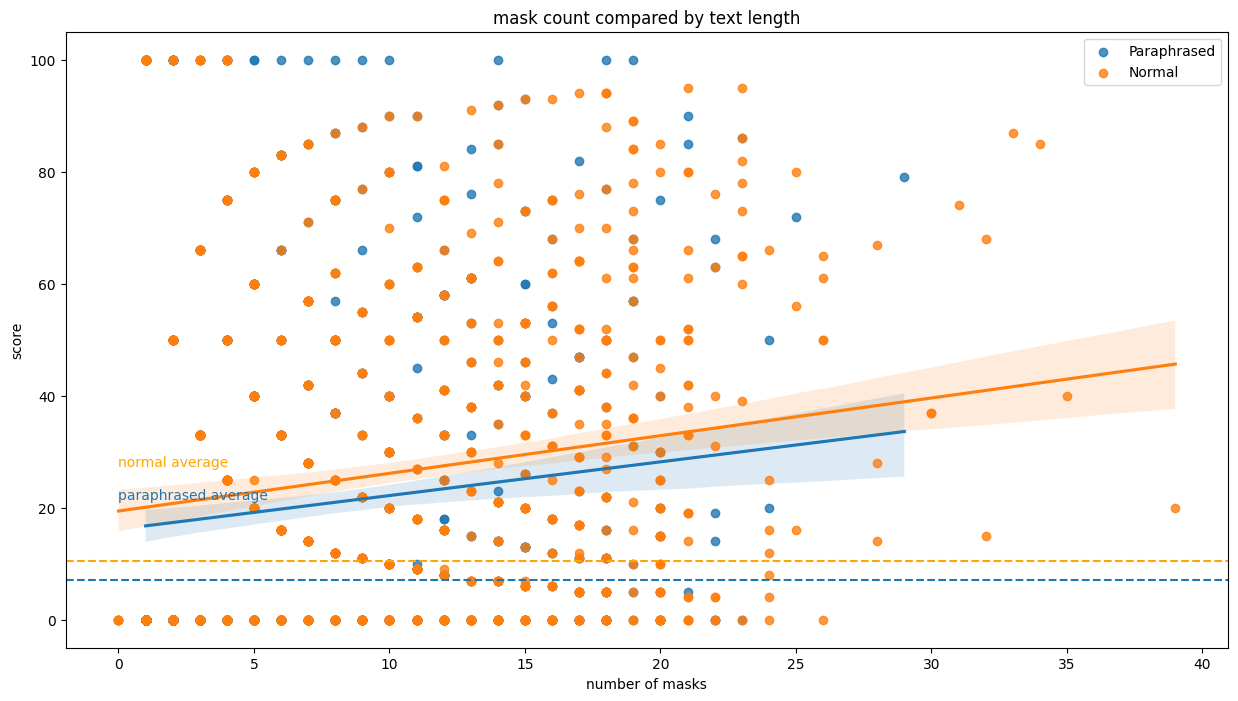

In [23]:
# compare number of masks to scores
## Compare length of text to number of masks
plt.pyplot.figure(figsize=(15,8))
nf = sns.regplot(x=df['paraphrased_mask_count'], y=df['paraphrased_scores'], label='Paraphrased')
nf = sns.regplot(x=df['normal_mask_count'], y=df['normal_scores'], label='Normal')
# nf.set_ylim(0, 50)
# nf.set_xlim(50)
nf.axhline(df['normal_mask_count'].mean(), ls='--', c='orange')
nf.axhline(df['paraphrased_mask_count'].mean(), ls='--')
nf.set(xlabel='number of masks')
nf.set(ylabel='score')
nf.text(0, df['paraphrased_scores'].mean()+1, "paraphrased average", c='C0')
nf.text(0, df['normal_scores'].mean()+1, "normal average", c='orange')
nf.legend()
nf.set_title("mask count compared by text length")


## Difference in number of masks vs entities
If everything went right, the number of masks should equal the number of entities detected by NER (filtered by name). However on average there are 7.5 more masks than detected entities (see below). This means strings were replaced with masks without being marked by NER.

Averages of:
number of entities: 10.48
number of masks: 10.48
difference masks - entities: 0.0


Text(0.5, 1.0, 'mask count compared by number of detected entities')

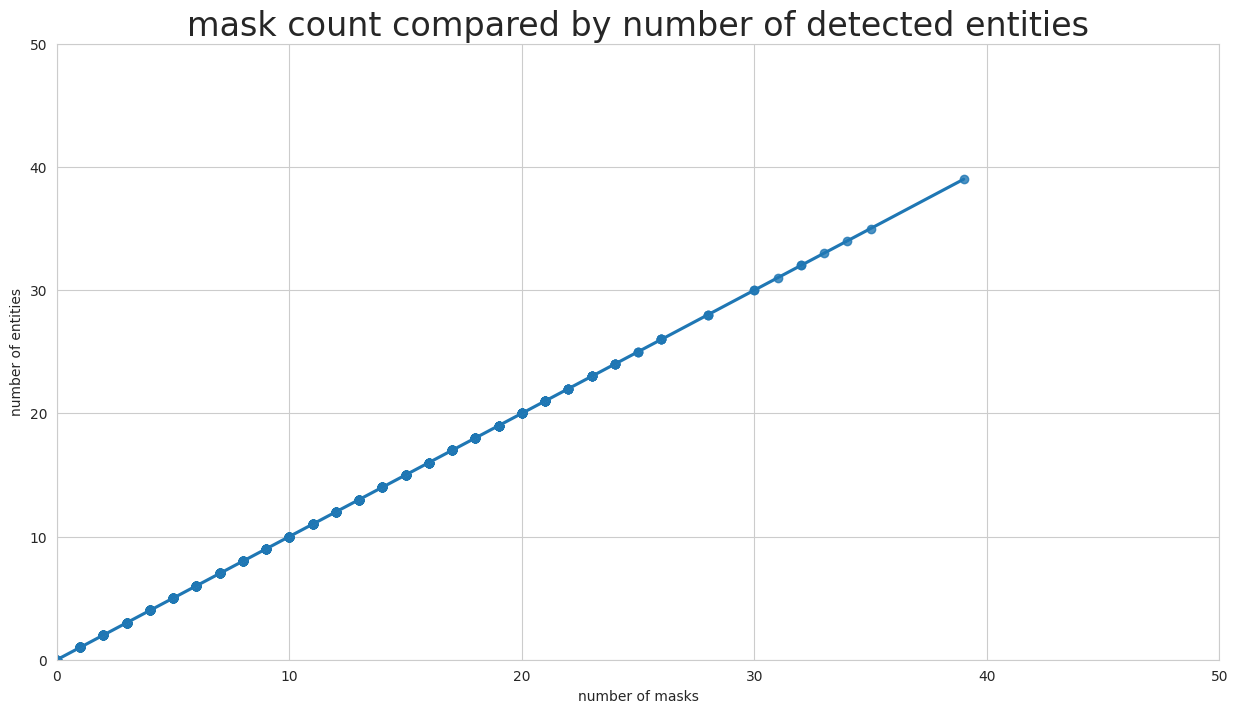

In [24]:
avg = round(df[['normal_mask_count', 'normal_entities_count']].apply(lambda row: row['normal_mask_count'] - row['normal_entities_count'], axis=1).mean(),2)
print("Averages of:")
print("number of entities: {}".format(round(df['normal_entities_count'].mean(),2)))
print("number of masks: {}".format(round(df['normal_mask_count'].mean(),2)))
print("difference masks - entities: {}".format(avg))
sns.set_style("whitegrid")
plt.pyplot.figure(figsize=(15,8))
nf = sns.regplot(x=df['normal_mask_count'], y=df['normal_entities_count'], label='Paraphrased')
nf.set_ylim(0, 50)
nf.grid(True)
nf.set_xlim(0, 50)
sns.set(font_scale=2)
nf.set_xlabel('number of masks')
nf.set(ylabel='number of entities')
nf.set_title("mask count compared by number of detected entities")

## Compare difference of sentences between normal and paraphrased

In [27]:
df.keys()

Index(['id', 'raw', 'title', 'url', 'sentences', 'paraphrased_sentences',
       'normal_text', 'paraphrased_text', 'normal_masked_text',
       'normal_entities', 'paraphrased_masked_text', 'paraphrased_entities',
       'batched_sentences', 'paraphrased_batched_sentences',
       'batched_normal_text', 'batched_paraphrased_text', 'normal_predictions',
       'paraphrased_predictions', 'normal_prediction_tokens',
       'paraphrased_prediction_tokens', 'normal_scores', 'paraphrased_scores',
       'normal_text_length', 'paraphrased_text_length',
       'normal_sentences_count', 'paraphrased_sentences_count',
       'normal_mask_count', 'paraphrased_mask_count', 'normal_entities_count',
       'paraphrased_entities_count'],
      dtype='object')

In [32]:
df.iloc[0]['sentences']

['George Washington (February 22, 1732, 1799) was an American soldier, statesman, and Founding Father who served as the first president of the United States from 1789 to 1797.',
 'Appointed by the Continental Congress as commander of the Continental Army, Washington led the Patriot forces to victory in the American Revolutionary War, and presided at the Constitutional Convention of 1787, which established the Constitution of the United States and a federal government.',
 'Washington has been called the "Father of the Nation" for his manifold leadership in the formative days of the country.',
 "Washington's first public office was serving as official Surveyor of Culpeper County, Virginia from 1749 to 1750.",
 'Subsequently, he received his initial military training (as well as a command with the Virginia Regiment) during the French and Indian War.',
 'He was later elected to the Virginia House of Burgesses and was named a delegate to the Continental Congress.',
 'Here he was appointed C

In [34]:
len("George Washington was born on February 22, 1732, at Popes Creek in Westmoreland County, Virginia, and was the first of six children of Augustine and Mary Ball Washington.")

170

In [33]:
df.iloc[0]['paraphrased_sentences']

['George Washington was the first president of the United States from 1789 to 1797.',
 'Washington wasAppointed by the Continental Congress as commander of the Continental Army, and presided at the Constitutional Convention of 1787, which established the Constitution of the United States and a federal government.',
 'Washington was called the "Father of the Nation" for his leadership in the early days of the country.',
 "From 1749 to 1750, Washington's first public office was the official Surveyor of Culpeper County, Virginia.",
 'During the French and Indian War, he received his initial military training as well as a command.',
 'He became a delegate to the Continental Congress after being elected to the Virginia House of Burgesses.',
 'He was the Commanding General of the Continental Army.',
 'He commanded American forces in the defeat and surrender of the British at the Siege of Yorktown during the American Revolutionary War.',
 'The Treaty of Paris was signed in 1783.',
 'The Const

## metric flooding
Compare all and any variable in the dataset to get a quick overview on which results might be interesting to compare or look at in more detail. Results are stored separately, commented and easier to read than within the notebook.

In [ ]:
%matplotlib inline
from autoviz.AutoViz_Class import AutoViz_Class

AV = AutoViz_Class()

In [ ]:
%matplotlib inline
filename = ""
sep = ","
dft = AV.AutoViz(
    filename="",
    depVar="",
    dfte=df,
    header=0,
    verbose=0,
    lowess=False,
    chart_format="svg",
    max_rows_analyzed=150000,
    max_cols_analyzed=30,
    save_plot_dir=None
)